In [15]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
from activation_func import *
from loss_func import *
import cv2
import pandas as pd

from tqdm.notebook import tqdm

In [36]:
def MakeOneHot(Y, D_out):
    N = Y.shape[0]
    Z = np.zeros((N, D_out))
    Z[np.arange(N), Y] = 1
    return Z

def draw_losses(losses):
    t = np.arange(len(losses))
    plt.plot(t, losses)
    plt.show()

def get_batch(X, Y, batch_size):
    N = len(X)
    i = random.randint(1, N-batch_size)
    return X[i:i+batch_size], Y[i:i+batch_size]

class FC():
    """
    Fully connected layer
    """
    def __init__(self, D_in, D_out):
        #print("Build FC")
        self.cache = None
        #self.W = {'val': np.random.randn(D_in, D_out), 'grad': 0}
        self.W = {'val': np.random.normal(0.0, np.sqrt(2/D_in), (D_in,D_out)), 'grad': 0}
        self.b = {'val': np.random.randn(D_out), 'grad': 0}

    def _forward(self, X):
        #print("FC: _forward")
        out = np.dot(X, self.W['val']) + self.b['val']
        self.cache = X
        return out

    def _backward(self, dout):
        #print("FC: _backward")
        X = self.cache
        dX = np.dot(dout, self.W['val'].T).reshape(X.shape)
        self.W['grad'] = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.b['grad'] = np.sum(dout, axis=0)
        #self._update_params()
        return dX

    def _update_params(self, lr=0.001):
        # Update the parameters
        self.W['val'] -= lr*self.W['grad']
        self.b['val'] -= lr*self.b['grad']



class Dropout():
    """
    Dropout layer
    """
    def __init__(self, p=1):
        self.cache = None
        self.p = p

    def _forward(self, X):
        M = (np.random.rand(*X.shape) < self.p) / self.p
        self.cache = X, M
        return X*M

    def _backward(self, dout):
        X, M = self.cache
        dX = dout*M/self.p
        return dX

class Conv:
    # 初始化权重（卷积核4维）、偏置、步幅、填充
    def __init__(self, Cin, Cout, X_H, X_W, F, stride, pad):

        self.stride = stride
        self.pad = pad
        # 中间数据（backward时使用）
        self.x = None   
        self.col = None
        self.col_W = None
        self.W = {'val': np.random.normal(0.0,np.sqrt(2/Cin),(Cout,Cin,F,F)), 'grad': 0} # Xavier Initialization
        self.b = {'val': np.random.randn(Cout), 'grad': 0}
        self.X_H = X_H
        self.X_W = X_W
        self.Cin = Cin

    def _forward(self, x):
        x = x.reshape(x.shape[0], self.Cin, self.X_H, self.X_W)
        # 卷积核大小
        FN, C, FH, FW = self.W['val'].shape
        # 数据数据大小
        N, C, H, W = x.shape
        # 计算输出数据大小
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        # 利用im2col转换为行
        col = im2col(x, FH, FW, self.stride, self.pad)
        # 卷积核转换为列，展开为2维数组
        col_W = self.W['val'].reshape(FN, -1).T
        # 计算正向传播
        out = np.dot(col, col_W) + self.b['val']
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def _backward(self, dout):
        # 卷积核大小
        FN, C, FH, FW = self.W['val'].shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        db = np.sum(dout, axis=0)
        dW = np.dot(self.col.T, dout)
        dW = dW.transpose(1, 0).reshape(FN, C, FH, FW)

        self.W['grad'] = dW
        self.b['grad'] = db

        dcol = np.dot(dout, self.col_W.T)
        # 逆转换
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

class MaxPool:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def _forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        # 展开
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        # 最大值
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # 转换
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def _backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


class Net(metaclass=ABCMeta):
    # Neural network super class

    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def forward(self, X):
        pass

    @abstractmethod
    def backward(self, dout):
        pass

    @abstractmethod
    def get_params(self):
        pass

    @abstractmethod
    def set_params(self, params):
        pass


class TwoLayerNet(Net):

    #Simple 2 layer NN

    def __init__(self, N, D_in, H, D_out, weights=''):
        self.FC1 = FC(D_in, H)
        self.ReLU1 = ReLU()
        self.FC2 = FC(H, D_out)

        if weights == '':
            pass
        else:
            with open(weights,'rb') as f:
                params = pickle.load(f)
                self.set_params(params)

    def forward(self, X):
        h1 = self.FC1._forward(X)
        a1 = self.ReLU1._forward(h1)
        h2 = self.FC2._forward(a1)
        return h2

    def backward(self, dout):
        dout = self.FC2._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.FC1._backward(dout)

    def get_params(self):
        return [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b]

    def set_params(self, params):
        [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b] = params


class ThreeLayerNet(Net):

    #Simple 3 layer NN

    def __init__(self, N, D_in, H1, H2, D_out, weights=''):
        self.FC1 = FC(D_in, H1)
        self.ReLU1 = ReLU()
        self.FC2 = FC(H1, H2)
        self.ReLU2 = ReLU()
        self.FC3 = FC(H2, D_out)

        if weights == '':
            pass
        else:
            with open(weights,'rb') as f:
                params = pickle.load(f)
                self.set_params(params)

    def forward(self, X):
        h1 = self.FC1._forward(X)
        a1 = self.ReLU1._forward(h1)
        h2 = self.FC2._forward(a1)
        a2 = self.ReLU2._forward(h2)
        h3 = self.FC3._forward(a2)
        return h3

    def backward(self, dout):
        dout = self.FC3._backward(dout)
        dout = self.ReLU2._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.FC1._backward(dout)

    def get_params(self):
        return [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params


class LeNet5(Net):
    # LeNet5

    def __init__(self):
        self.conv1 = Conv(3, 6, 64, 64, 3, 1, 0)
        self.ReLU1 = ReLU()
        self.pool1 = MaxPool(2,2)
        self.conv2 = Conv(6, 16, 31, 31, 3, 1, 0)
        self.ReLU2 = ReLU()
        self.pool2 = MaxPool(2,2)
        self.conv3 = Conv(16, 16, 14, 14, 3, 1, 0)
        self.ReLU3 = ReLU()
        self.pool3 = MaxPool(2,2)
        self.FC1 = FC(16*6*6, 120)
        self.ReLU4 = ReLU()
        self.FC2 = FC(120, 84)
        self.ReLU5 = ReLU()
        self.FC3 = FC(84, 50)
        self.Softmax = Softmax()
        self.p3_shape = None

    def forward(self, X):
        h1 = self.conv1._forward(X)
        a1 = self.ReLU1._forward(h1)
        p1 = self.pool1._forward(a1)
        h2 = self.conv2._forward(p1)
        a2 = self.ReLU2._forward(h2)
        p2 = self.pool2._forward(a2)
        h3 = self.conv3._forward(p2)
        a3 = self.ReLU3._forward(h3)
        p3 = self.pool3._forward(a3)
        self.p3_shape = p3.shape
        fl = p3.reshape(X.shape[0],-1) # Flatten
        h4 = self.FC1._forward(fl)
        a4 = self.ReLU4._forward(h4)
        h5 = self.FC2._forward(a4)
        a5 = self.ReLU5._forward(h5)
        h6 = self.FC3._forward(a5)
        a6 = self.Softmax._forward(h6)
        return a6

    def backward(self, dout):
        #dout = self.Softmax._backward(dout)
        dout = self.FC3._backward(dout)
        dout = self.ReLU5._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.ReLU4._backward(dout)
        dout = self.FC1._backward(dout)
        dout = dout.reshape(self.p3_shape) # reshape
        dout = self.pool3._backward(dout)
        dout = self.ReLU3._backward(dout)
        dout = self.conv3._backward(dout)        
        dout = self.pool2._backward(dout)
        dout = self.ReLU2._backward(dout)
        dout = self.conv2._backward(dout)
        dout = self.pool1._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.conv1._backward(dout)

    def get_params(self):
        return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params

class SGD():
    def __init__(self, params, lr=0.001, reg=0):
        self.parameters = params
        self.lr = lr
        self.reg = reg

    def step(self):
        for param in self.parameters:
            param['val'] -= (self.lr*param['grad'] + self.reg*param['val'])

class SGDMomentum():
    def __init__(self, params, lr=0.001, momentum=0.99, reg=0):
        self.l = len(params)
        self.parameters = params
        self.velocities = []
        for param in self.parameters:
            self.velocities.append(np.zeros(param['val'].shape))
        self.lr = lr
        self.rho = momentum
        self.reg = reg

    def step(self):
        for i in range(self.l):
            self.velocities[i] = self.rho*self.velocities[i] + (1-self.rho)*self.parameters[i]['grad']
            self.parameters[i]['val'] -= (self.lr*self.velocities[i] + self.reg*self.parameters[i]['val'])


In [17]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):

    # 输入数据的形状
    # N：批数目，C：通道数，H：输入数据高，W：输入数据长
    N, C, H, W = input_data.shape  
    out_h = (H + 2*pad - filter_h)//stride + 1  # 输出数据的高
    out_w = (W + 2*pad - filter_w)//stride + 1  # 输出数据的长
    # 填充 H,W
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    # (N, C, filter_h, filter_w, out_h, out_w)的0矩阵
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    # 按(0, 4, 5, 1, 2, 3)顺序，交换col的列，然后改变形状
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## Data Preprocessing

In [18]:
trainDF = pd.read_csv("train.txt", sep=" ", header = None)
trainDF.columns = ["file_path", "img_label"]

valDF = pd.read_csv("val.txt", sep=" ", header = None)
valDF.columns = ["file_path", "img_label"]

testDF = pd.read_csv("test.txt", sep=" ", header = None)
testDF.columns = ["file_path", "img_label"]

In [102]:
DFname = ["trainDF", "valDF", "testDF"]

for i_df in DFname:
    for idx in tqdm(range(len(eval(i_df)))):
        image = cv2.imread(eval(i_df).iloc[idx, 0])
        img1 = cv2.resize(image, (64, 64)) #size -> (64,64,3)
        if idx == 0:
            ### example code: train_img=np.expand_dims(img1, axis=0)
            eval('exec(i_df+"array"+"=np.expand_dims(img1, axis=0)")') #新增樣本數維度 #size -> (1,64,64,3)
        else:
            ### example code: train_img=np.appensd(train_img, np.expand_dims(img1, axis=0),axis=0)
            ### output: trainDFarray,valDFarray, testDFarray
            eval('''exec(i_df+"array"+'=np.append(eval(i_df+"array"), np.expand_dims(img1, axis=0), axis=0)')''')

  0%|          | 0/63325 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

## save and read resize image array

In [58]:
with open('train.npy', 'wb') as f:
    np.save(f, trainDFarray)
with open('test.npy', 'wb') as f:
    np.save(f, testDFarray)
with open('val.npy', 'wb') as f:
    np.save(f, valDFarray)

(64, 1, 28, 28)

In [19]:
with open('train.npy', 'rb') as f:
    trainDFarray = np.load(f)  
with open('test.npy', 'rb') as f:
    testDFarray = np.load(f)
with open('val.npy', 'rb') as f:
    valDFarray = np.load(f)

## train model

iter: 0, loss: 3.944902185917391
iter: 1, loss: 3.944689835204179
iter: 2, loss: 3.9450965112360223
iter: 3, loss: 3.91821347094252
iter: 4, loss: 3.94581133271106
iter: 5, loss: 3.94581133271106
iter: 6, loss: 3.94581133271106
iter: 7, loss: 3.94581133271106
iter: 8, loss: 3.94581133271106
iter: 9, loss: 3.94581133271106
iter: 10, loss: 3.94581133271106
iter: 11, loss: 3.94581133271106
iter: 12, loss: 3.945809632180043
iter: 13, loss: 3.9458113315403414
iter: 14, loss: 3.945811332617475
iter: 15, loss: 3.9458112782059493
iter: 16, loss: 2.9458125176907846
iter: 17, loss: 3.94581133271106
iter: 18, loss: 3.94581133271106
iter: 19, loss: 3.94581133271106
iter: 20, loss: 3.94581133271106
iter: 21, loss: 3.94581133271106
iter: 22, loss: 3.94581133271106
iter: 23, loss: 3.9458113327110325
iter: 24, loss: 3.9458113327110595
iter: 25, loss: 3.945811332704503
iter: 26, loss: 3.9458092325386223
iter: 27, loss: 3.9458113268753694
iter: 28, loss: 3.945759649202408
iter: 29, loss: 3.9455689300556

iter: 236, loss: 3.937177548757737
iter: 237, loss: 3.938029602325174
iter: 238, loss: 3.937604277253354
iter: 239, loss: 3.9379201705986673
iter: 240, loss: 3.939167867583829
iter: 241, loss: 3.939575364793101
iter: 242, loss: 3.941694419098885
iter: 243, loss: 3.940800115323307
iter: 244, loss: 3.9433945407736726
iter: 245, loss: 2.9809920275586697
iter: 246, loss: 3.9449593034711117
iter: 247, loss: 3.9454628065781656
iter: 248, loss: 3.9454992761673005
iter: 249, loss: 3.945607296973228
iter: 250, loss: 3.9455364470305074
iter: 251, loss: 3.945639194769514
iter: 252, loss: 3.9456254493441336
iter: 253, loss: 3.945646938741813
iter: 254, loss: 3.9455745470635613
iter: 255, loss: 3.944825355276881
iter: 256, loss: 3.9456153765822255
iter: 257, loss: 3.9456003879906056
iter: 258, loss: 3.9455929841406543
iter: 259, loss: 3.944828510412756
iter: 260, loss: 3.9127905577010416
iter: 261, loss: 3.9442050009210874
iter: 262, loss: 3.9435638550501997
iter: 263, loss: 3.9427264184671524
iter

iter: 468, loss: 3.922033503417669
iter: 469, loss: 3.9318683526157407
iter: 470, loss: 3.931980887105091
iter: 471, loss: 3.935213372714966
iter: 472, loss: 3.9363311856794625
iter: 473, loss: 3.937861775375813
iter: 474, loss: 3.9314413549802216
iter: 475, loss: 3.9355223043580163
iter: 476, loss: 3.9329258762832335
iter: 477, loss: 3.9352217402591108
iter: 478, loss: 3.634826635564946
iter: 479, loss: 3.933951486234308
iter: 480, loss: 3.936081011170376
iter: 481, loss: 3.936019099046249
iter: 482, loss: 3.9361481971596177
iter: 483, loss: 3.936822342187604
iter: 484, loss: 3.9077171294023314
iter: 485, loss: 3.9403998556302717
iter: 486, loss: 3.941833936195185
iter: 487, loss: 3.942171961691067
iter: 488, loss: 3.9422773087007648
iter: 489, loss: 3.9421321013514805
iter: 490, loss: 3.9422174212766046
iter: 491, loss: 3.942196559026452
iter: 492, loss: 3.942224719458681
iter: 493, loss: 3.942294813199428
iter: 494, loss: 3.9422646308004996
iter: 495, loss: 3.9420650064003353
iter: 

iter: 699, loss: 3.9374344279354565
iter: 700, loss: 3.937092783844991
iter: 701, loss: 3.936823567745612
iter: 702, loss: 3.936472781116802
iter: 703, loss: 3.9366353436353543
iter: 704, loss: 3.9363305569213876
iter: 705, loss: 3.936950129647074
iter: 706, loss: 3.9363298760512606
iter: 707, loss: 3.936399934796714
iter: 708, loss: 3.935983086861786
iter: 709, loss: 3.936125360853253
iter: 710, loss: 3.9362310580316224
iter: 711, loss: 3.9360208639494907
iter: 712, loss: 3.93608339288822
iter: 713, loss: 3.935744994289128
iter: 714, loss: 3.9362144676221096
iter: 715, loss: 3.9360496778489598
iter: 716, loss: 3.9359672838087274
iter: 717, loss: 3.9358818622689764
iter: 718, loss: 3.93583867679883
iter: 719, loss: 3.9358447544601
iter: 720, loss: 3.9358004241288573
iter: 721, loss: 3.935594534623982
iter: 722, loss: 3.935696253671775
iter: 723, loss: 3.935814764262866
iter: 724, loss: 3.935603252145461
iter: 725, loss: 3.9356772378279836
iter: 726, loss: 3.935076895820366
iter: 727, l

iter: 930, loss: 3.9313188461309836
iter: 931, loss: 3.934092853457058
iter: 932, loss: 3.9338311572644957
iter: 933, loss: 3.9338040435753574
iter: 934, loss: 3.9335722433510067
iter: 935, loss: 3.804511017345752
iter: 936, loss: 3.7889829038760805
iter: 937, loss: 3.9336345668800825
iter: 938, loss: 3.9331617697128083
iter: 939, loss: 3.9335672816675857
iter: 940, loss: 3.9328042438260367
iter: 941, loss: 3.7184259026405804
iter: 942, loss: 3.9322846221113843
iter: 943, loss: 3.9330012548065167
iter: 944, loss: 3.9330507046361807
iter: 945, loss: 3.9337868790232458
iter: 946, loss: 3.9335090403267996
iter: 947, loss: 3.9308360287120485
iter: 948, loss: 3.9336523607964686
iter: 949, loss: 3.932150240998434
iter: 950, loss: 3.933674634291846
iter: 951, loss: 3.928626371357737
iter: 952, loss: 3.933222403982547
iter: 953, loss: 3.9322582777229123
iter: 954, loss: 3.933590365625468
iter: 955, loss: 3.933906209899464
iter: 956, loss: 3.9330853872661016
iter: 957, loss: 3.933211061618093
i

iter: 1157, loss: 3.938533718493624
iter: 1158, loss: 3.9385028541960705
iter: 1159, loss: 3.938614376891805
iter: 1160, loss: 3.938544924768703
iter: 1161, loss: 3.9375982432252643
iter: 1162, loss: 3.937552375278033
iter: 1163, loss: 3.9375896872019758
iter: 1164, loss: 3.9385896525917325
iter: 1165, loss: 3.9361757826443333
iter: 1166, loss: 3.938150006439238
iter: 1167, loss: 3.9193978672273393
iter: 1168, loss: 3.9372259092059068
iter: 1169, loss: 3.936950209494243
iter: 1170, loss: 3.9372751410463342
iter: 1171, loss: 3.938546747749344
iter: 1172, loss: 3.9374413062049314
iter: 1173, loss: 3.937725044712251
iter: 1174, loss: 3.9378215692637326
iter: 1175, loss: 3.9354792732790576
iter: 1176, loss: 3.935162863690611
iter: 1177, loss: 3.9368297341741862
iter: 1178, loss: 3.936571833907496
iter: 1179, loss: 3.936750902543067
iter: 1180, loss: 3.937144681863391
iter: 1181, loss: 3.936922831563282
iter: 1182, loss: 3.936370459182878
iter: 1183, loss: 3.9362118421703904
iter: 1184, los

iter: 1382, loss: 3.9360704935451114
iter: 1383, loss: 3.934703960066559
iter: 1384, loss: 3.930461156855483
iter: 1385, loss: 3.9265816958787245
iter: 1386, loss: 3.924728335703934
iter: 1387, loss: 3.9256189199117832
iter: 1388, loss: 3.935091042074245
iter: 1389, loss: 3.93516509686053
iter: 1390, loss: 3.9234539218660385
iter: 1391, loss: 3.9354329716283383
iter: 1392, loss: 3.935395552692808
iter: 1393, loss: 3.9151513777641203
iter: 1394, loss: 3.9142963521696377
iter: 1395, loss: 3.93596038476487
iter: 1396, loss: 3.9352105293614246
iter: 1397, loss: 3.935057985123055
iter: 1398, loss: 3.9353404496700923
iter: 1399, loss: 3.935325141936257
iter: 1400, loss: 3.9333677974542858
iter: 1401, loss: 3.8864993686864198
iter: 1402, loss: 3.934787619672327
iter: 1403, loss: 3.9150065483161485
iter: 1404, loss: 3.908644265378532
iter: 1405, loss: 3.9348035120638367
iter: 1406, loss: 3.8942441467145597
iter: 1407, loss: 3.9342006356572723
iter: 1408, loss: 3.862975211203346
iter: 1409, los

iter: 1607, loss: 3.9175227427340467
iter: 1608, loss: 3.9341423256763535
iter: 1609, loss: 3.9341429357958995
iter: 1610, loss: 3.935011150637447
iter: 1611, loss: 3.9338697101518685
iter: 1612, loss: 3.9328272766150145
iter: 1613, loss: 3.9330840831152307
iter: 1614, loss: 3.9334265132962316
iter: 1615, loss: 3.9202229328940055
iter: 1616, loss: 3.9331057619354786
iter: 1617, loss: 3.8878987884684886
iter: 1618, loss: 3.9183139816920463
iter: 1619, loss: 3.9252046727932943
iter: 1620, loss: 3.9319644529067714
iter: 1621, loss: 3.9129009259338403
iter: 1622, loss: 3.9300094266762846
iter: 1623, loss: 3.9323236859153954
iter: 1624, loss: 3.931492457796681
iter: 1625, loss: 3.8220111727910906
iter: 1626, loss: 3.931258167757389
iter: 1627, loss: 3.9317559337401975
iter: 1628, loss: 3.9301490010417126
iter: 1629, loss: 3.9319114394491494
iter: 1630, loss: 3.9202715794563674
iter: 1631, loss: 3.935876942155815
iter: 1632, loss: 3.918486993845409
iter: 1633, loss: 3.923394900506956
iter: 1

iter: 1832, loss: 3.9315909253689645
iter: 1833, loss: 3.933923229923605
iter: 1834, loss: 3.9344419259629873
iter: 1835, loss: 3.8769287649273254
iter: 1836, loss: 3.6520593157889882
iter: 1837, loss: 3.8811352407818362
iter: 1838, loss: 3.9338232697735522
iter: 1839, loss: 3.932159805447511
iter: 1840, loss: 3.934029013517159
iter: 1841, loss: 3.9330683128092536
iter: 1842, loss: 3.934460753656332
iter: 1843, loss: 3.9298359136685668
iter: 1844, loss: 3.934754599486513
iter: 1845, loss: 3.9341929104622873
iter: 1846, loss: 3.918834959175621
iter: 1847, loss: 3.932969909137233
iter: 1848, loss: 3.9344673735343867
iter: 1849, loss: 3.934037174737915
iter: 1850, loss: 3.934185029039552
iter: 1851, loss: 3.9007296207246687
iter: 1852, loss: 3.932389293106732
iter: 1853, loss: 3.9341245111818113
iter: 1854, loss: 3.9347300934702276
iter: 1855, loss: 3.4951071441350203
iter: 1856, loss: 3.933075386184964
iter: 1857, loss: 3.9348068574196695
iter: 1858, loss: 3.9318881194050905
iter: 1859, 

iter: 2057, loss: 3.9368271104677275
iter: 2058, loss: 3.9388265902149664
iter: 2059, loss: 3.939186789318628
iter: 2060, loss: 3.937234313877528
iter: 2061, loss: 3.938013359758596
iter: 2062, loss: 3.9344348344090876
iter: 2063, loss: 3.9377804079856222
iter: 2064, loss: 3.9356449362341035
iter: 2065, loss: 3.9381836963651056
iter: 2066, loss: 3.930198896849385
iter: 2067, loss: 3.9359594804321345
iter: 2068, loss: 3.937118642409339
iter: 2069, loss: 3.9125074652244205
iter: 2070, loss: 3.924723222549046
iter: 2071, loss: 3.9362776879642305
iter: 2072, loss: 3.937202437067847
iter: 2073, loss: 3.9323336739353665
iter: 2074, loss: 3.933105959895674
iter: 2075, loss: 3.908899307497868
iter: 2076, loss: 3.9110252563621244
iter: 2077, loss: 3.92833968202517
iter: 2078, loss: 3.927737478868686
iter: 2079, loss: 3.9334057472742288
iter: 2080, loss: 3.8988135287991668
iter: 2081, loss: 3.9334612682382377
iter: 2082, loss: 3.928242001761091
iter: 2083, loss: 3.930190554811911
iter: 2084, los

iter: 2282, loss: 3.9012419047370446
iter: 2283, loss: 3.9270838451700065
iter: 2284, loss: 3.935660486161322
iter: 2285, loss: 3.935870200693041
iter: 2286, loss: 3.9334569695156176
iter: 2287, loss: 3.935287126710882
iter: 2288, loss: 3.936938805886672
iter: 2289, loss: 3.8957627628291185
iter: 2290, loss: 3.873849804656808
iter: 2291, loss: 3.937988171031333
iter: 2292, loss: 3.9371221859434087
iter: 2293, loss: 3.9392741297952156
iter: 2294, loss: 3.929051311104406
iter: 2295, loss: 3.2383585944600566
iter: 2296, loss: 3.935076410531534
iter: 2297, loss: 3.936412649823238
iter: 2298, loss: 3.936520675999721
iter: 2299, loss: 3.9334079032505973
iter: 2300, loss: 3.9389150998533564
iter: 2301, loss: 3.93504984687293
iter: 2302, loss: 3.853297102302244
iter: 2303, loss: 3.9359836057390045
iter: 2304, loss: 3.9367930236561226
iter: 2305, loss: 3.9378029604928146
iter: 2306, loss: 3.936993993052203
iter: 2307, loss: 3.936828751705374
iter: 2308, loss: 3.9371199547237548
iter: 2309, loss

iter: 2507, loss: 3.9105812975410394
iter: 2508, loss: 3.935980981744301
iter: 2509, loss: 3.9356207825051093
iter: 2510, loss: 3.925920019928286
iter: 2511, loss: 3.913630935592952
iter: 2512, loss: 3.9343440252839645
iter: 2513, loss: 3.9373978662941735
iter: 2514, loss: 3.9336494251369603
iter: 2515, loss: 3.9334857907015124
iter: 2516, loss: 3.9335617610806852
iter: 2517, loss: 3.9321935790366345
iter: 2518, loss: 3.910577996711806
iter: 2519, loss: 3.9323324055880238
iter: 2520, loss: 3.7978544067315885
iter: 2521, loss: 3.932218532706139
iter: 2522, loss: 3.928732162804375
iter: 2523, loss: 3.9050314205712726
iter: 2524, loss: 3.932003418418546
iter: 2525, loss: 3.931358286020166
iter: 2526, loss: 3.909881108787568
iter: 2527, loss: 3.9296560011377473
iter: 2528, loss: 3.928617912251405
iter: 2529, loss: 3.9282692257419676
iter: 2530, loss: 3.8908453751613363
iter: 2531, loss: 3.746560593400576
iter: 2532, loss: 3.661989919123075
iter: 2533, loss: 3.8135169176960573
iter: 2534, l

iter: 2732, loss: 3.9251626137931126
iter: 2733, loss: 3.9067740099027053
iter: 2734, loss: 3.934164987308865
iter: 2735, loss: 3.9321641086735633
iter: 2736, loss: 3.9214540968593776
iter: 2737, loss: 3.9361455698676178
iter: 2738, loss: 3.9374869315662426
iter: 2739, loss: 3.936438331493534
iter: 2740, loss: 3.932683059541315
iter: 2741, loss: 3.8810121941702347
iter: 2742, loss: 3.936878580783095
iter: 2743, loss: 3.9208961328394736
iter: 2744, loss: 3.9369928994143
iter: 2745, loss: 3.9376186530774553
iter: 2746, loss: 3.9364423836792555
iter: 2747, loss: 3.937437120001142
iter: 2748, loss: 3.9254196072835885
iter: 2749, loss: 3.9374206581690383
iter: 2750, loss: 3.9354721819744336
iter: 2751, loss: 3.938084261911526
iter: 2752, loss: 3.931436119338736
iter: 2753, loss: 3.909779394838629
iter: 2754, loss: 3.9360950733444073
iter: 2755, loss: 3.930286522996217
iter: 2756, loss: 3.90305091873698
iter: 2757, loss: 3.9362738889317392
iter: 2758, loss: 3.8931518034941375
iter: 2759, los

iter: 2957, loss: 3.9360100192522935
iter: 2958, loss: 3.933836298874949
iter: 2959, loss: 3.935773552034867
iter: 2960, loss: 3.93574753788559
iter: 2961, loss: 3.9359231743235474
iter: 2962, loss: 3.9330022184743245
iter: 2963, loss: 3.5495442633821614
iter: 2964, loss: 3.9357874593951445
iter: 2965, loss: 3.9359836028082444
iter: 2966, loss: 3.935717111409786
iter: 2967, loss: 3.935918865591311
iter: 2968, loss: 3.9355176724029874
iter: 2969, loss: 3.9326178092332946
iter: 2970, loss: 3.9357077448356286
iter: 2971, loss: 3.6978319145381042
iter: 2972, loss: 3.932224318951773
iter: 2973, loss: 3.935607956491312
iter: 2974, loss: 3.9344045603714166
iter: 2975, loss: 3.925831591872461
iter: 2976, loss: 3.9354960241517896
iter: 2977, loss: 3.932978328358956
iter: 2978, loss: 3.933344246401425
iter: 2979, loss: 3.930967390329102
iter: 2980, loss: 3.9239636185349713
iter: 2981, loss: 3.9321019072843857
iter: 2982, loss: 3.9358883485118956
iter: 2983, loss: 3.935857530993305
iter: 2984, lo

iter: 3182, loss: 3.9314044666171046
iter: 3183, loss: 3.9315368695897446
iter: 3184, loss: 3.933405873172717
iter: 3185, loss: 3.931464759408876
iter: 3186, loss: 3.931503380349043
iter: 3187, loss: 3.928546351808107
iter: 3188, loss: 3.933761742753496
iter: 3189, loss: 3.931604396380261
iter: 3190, loss: 3.898596489346402
iter: 3191, loss: 3.8811119451169067
iter: 3192, loss: 3.9186187475320162
iter: 3193, loss: 3.9310046769250837
iter: 3194, loss: 3.8764224946777426
iter: 3195, loss: 3.9177734072715955
iter: 3196, loss: 3.916591410865908
iter: 3197, loss: 3.6466576977093705
iter: 3198, loss: 3.931076432396472
iter: 3199, loss: 3.933694858405058
iter: 3200, loss: 3.931444090801262
iter: 3201, loss: 3.933744254948599
iter: 3202, loss: 3.9339969119223226
iter: 3203, loss: 3.9311959951768918
iter: 3204, loss: 3.9334948992077043
iter: 3205, loss: 3.8930140501411574
iter: 3206, loss: 3.9311491242516095
iter: 3207, loss: 3.6194314767225197
iter: 3208, loss: 3.9161276125530593
iter: 3209, l

iter: 3406, loss: 3.9261053024984744
iter: 3407, loss: 3.8234791502092134
iter: 3408, loss: 3.9253220794823918
iter: 3409, loss: 3.931700063664637
iter: 3410, loss: 3.932673485537435
iter: 3411, loss: 3.9222749832409085
iter: 3412, loss: 3.931908417164589
iter: 3413, loss: 3.904876096213856
iter: 3414, loss: 3.903844794725889
iter: 3415, loss: 3.92526893409304
iter: 3416, loss: 3.9325703520485216
iter: 3417, loss: 3.922212114055001
iter: 3418, loss: 3.8573853956439095
iter: 3419, loss: 3.92740526233412
iter: 3420, loss: 3.9324382817604904
iter: 3421, loss: 3.923834195601253
iter: 3422, loss: 3.9241911733923134
iter: 3423, loss: 3.931319441964655
iter: 3424, loss: 3.932729789338141
iter: 3425, loss: 3.9205467984461224
iter: 3426, loss: 3.843291129853045
iter: 3427, loss: 3.779984556420468
iter: 3428, loss: 3.910638287180687
iter: 3429, loss: 3.9277436540072674
iter: 3430, loss: 3.7204006465270862
iter: 3431, loss: 3.930295737385567
iter: 3432, loss: 3.7670404069559353
iter: 3433, loss: 

iter: 3631, loss: 3.932449475040117
iter: 3632, loss: 3.933089880411534
iter: 3633, loss: 3.9243574711407803
iter: 3634, loss: 3.934099186177256
iter: 3635, loss: 3.8738179236688333
iter: 3636, loss: 3.6470640360631945
iter: 3637, loss: 3.929221201878307
iter: 3638, loss: 3.9326425936495104
iter: 3639, loss: 3.87356536821945
iter: 3640, loss: 3.861689465134774
iter: 3641, loss: 3.93221774809345
iter: 3642, loss: 3.9341681796910333
iter: 3643, loss: 3.935723534722115
iter: 3644, loss: 3.9358018342074934
iter: 3645, loss: 3.9359446744729127
iter: 3646, loss: 3.9340252174490504
iter: 3647, loss: 3.931961134309328
iter: 3648, loss: 3.93340719331029
iter: 3649, loss: 3.92744347581585
iter: 3650, loss: 3.935142219118012
iter: 3651, loss: 3.9295944373196967
iter: 3652, loss: 3.346777304263831
iter: 3653, loss: 3.935731025122015
iter: 3654, loss: 3.9321994701104286
iter: 3655, loss: 3.932821765831126
iter: 3656, loss: 3.934748278471745
iter: 3657, loss: 3.9371319300906458
iter: 3658, loss: 3.8

iter: 3857, loss: 3.945414376994261
iter: 3858, loss: 3.94578427765601
iter: 3859, loss: 3.9444012338912073
iter: 3860, loss: 3.9457436810678215
iter: 3861, loss: 3.945086048766323
iter: 3862, loss: 3.9457437521481262
iter: 3863, loss: 3.9454741275807272
iter: 3864, loss: 3.94505699962355
iter: 3865, loss: 3.9445658078146537
iter: 3866, loss: 3.945524234245911
iter: 3867, loss: 3.944841791953352
iter: 3868, loss: 3.9446087347248677
iter: 3869, loss: 3.945740611776268
iter: 3870, loss: 3.945305424318946
iter: 3871, loss: 3.944600911691035
iter: 3872, loss: 3.945265427398738
iter: 3873, loss: 3.944118584873702
iter: 3874, loss: 3.944545236396286
iter: 3875, loss: 3.934495354575243
iter: 3876, loss: 3.9450124729346325
iter: 3877, loss: 3.945614332991858
iter: 3878, loss: 3.944730651193721
iter: 3879, loss: 3.943140255048609
iter: 3880, loss: 3.9440932755786484
iter: 3881, loss: 3.9453275661007785
iter: 3882, loss: 3.945113418973492
iter: 3883, loss: 3.943981618768767
iter: 3884, loss: 3.9

iter: 4082, loss: 3.942421959496251
iter: 4083, loss: 3.9422523375740113
iter: 4084, loss: 3.941916506349374
iter: 4085, loss: 3.9415571773302536
iter: 4086, loss: 3.9411966632556816
iter: 4087, loss: 3.9407908751057548
iter: 4088, loss: 3.94044616547901
iter: 4089, loss: 3.940123814379262
iter: 4090, loss: 3.939877958647919
iter: 4091, loss: 3.939485835458248
iter: 4092, loss: 3.9390712802900527
iter: 4093, loss: 3.938684377151896
iter: 4094, loss: 3.938298896590163
iter: 4095, loss: 3.9378120570000816
iter: 4096, loss: 3.880737400016109
iter: 4097, loss: 3.9359867390424985
iter: 4098, loss: 3.935672079147793
iter: 4099, loss: 3.935282792678947
iter: 4100, loss: 3.931337224591969
iter: 4101, loss: 3.936807471444128
iter: 4102, loss: 3.9379757765495866
iter: 4103, loss: 3.872500705008975
iter: 4104, loss: 3.937880195866597
iter: 4105, loss: 3.9347994633138517
iter: 4106, loss: 3.9363640584454984
iter: 4107, loss: 3.9364961395832285
iter: 4108, loss: 3.937097250562807
iter: 4109, loss: 

iter: 4307, loss: 3.9446229851417063
iter: 4308, loss: 3.8519582245411907
iter: 4309, loss: 3.938447984306718
iter: 4310, loss: 3.938711358258183
iter: 4311, loss: 3.942133149432061
iter: 4312, loss: 3.944087159958805
iter: 4313, loss: 3.944894389823314
iter: 4314, loss: 3.9452898910901415
iter: 4315, loss: 3.9454751903718592
iter: 4316, loss: 3.938179708439612
iter: 4317, loss: 3.945283816006368
iter: 4318, loss: 3.9448078048020303
iter: 4319, loss: 3.9440895598238566
iter: 4320, loss: 3.943157004389412
iter: 4321, loss: 3.942100831456207
iter: 4322, loss: 3.9408576863537292
iter: 4323, loss: 3.9397331408169585
iter: 4324, loss: 3.9389152939587557
iter: 4325, loss: 3.9382538832970866
iter: 4326, loss: 3.9378080156704725
iter: 4327, loss: 3.9376449170019545
iter: 4328, loss: 3.478509819607047
iter: 4329, loss: 3.939350649225794
iter: 4330, loss: 3.9421399386797287
iter: 4331, loss: 3.943785361006148
iter: 4332, loss: 3.9445478870551427
iter: 4333, loss: 3.944932658431036
iter: 4334, lo

iter: 4532, loss: 3.9344841150454712
iter: 4533, loss: 3.93444520635498
iter: 4534, loss: 3.934383468566664
iter: 4535, loss: 3.9142878225111066
iter: 4536, loss: 3.9342662062753035
iter: 4537, loss: 3.934172483919315
iter: 4538, loss: 3.9340580253252977
iter: 4539, loss: 3.9339516408549002
iter: 4540, loss: 3.9339030292345503
iter: 4541, loss: 3.9338707277605356
iter: 4542, loss: 3.933845393000944
iter: 4543, loss: 3.9338185769844056
iter: 4544, loss: 3.9337973009039264
iter: 4545, loss: 3.933764875737916
iter: 4546, loss: 3.759124503991842
iter: 4547, loss: 3.9337686400680507
iter: 4548, loss: 3.7445750832440563
iter: 4549, loss: 3.909942394153433
iter: 4550, loss: 3.9343874057370565
iter: 4551, loss: 3.9345968873835417
iter: 4552, loss: 3.9347506376813115
iter: 4553, loss: 3.9348853789967095
iter: 4554, loss: 3.934938893546189
iter: 4555, loss: 3.9344627457361345
iter: 4556, loss: 3.93492828221352
iter: 4557, loss: 3.934873317863067
iter: 4558, loss: 3.856797186515955
iter: 4559, lo

iter: 4757, loss: 3.9373008526392237
iter: 4758, loss: 3.9342437086720903
iter: 4759, loss: 3.9366399249173862
iter: 4760, loss: 3.9364383329818007
iter: 4761, loss: 3.9362894912073827
iter: 4762, loss: 3.936151467531408
iter: 4763, loss: 3.93034756468353
iter: 4764, loss: 3.93195705291498
iter: 4765, loss: 3.9361167118411866
iter: 4766, loss: 3.92154279980824
iter: 4767, loss: 3.9360529699268914
iter: 4768, loss: 3.93593707093496
iter: 4769, loss: 3.935241323263432
iter: 4770, loss: 3.4518370668674754
iter: 4771, loss: 3.936561606388585
iter: 4772, loss: 3.7467067102744314
iter: 4773, loss: 3.93743729919715
iter: 4774, loss: 3.938267364880124
iter: 4775, loss: 3.93554797716957
iter: 4776, loss: 3.9385720539105042
iter: 4777, loss: 3.9339375931588445
iter: 4778, loss: 3.939150734829673
iter: 4779, loss: 3.9389728270487647
iter: 4780, loss: 3.9392802538890574
iter: 4781, loss: 3.9393387155010675
iter: 4782, loss: 3.937065279075229
iter: 4783, loss: 3.9388349176292095
iter: 4784, loss: 3

iter: 4982, loss: 3.9351652977067904
iter: 4983, loss: 3.9353422469654054
iter: 4984, loss: 3.9353178176820602
iter: 4985, loss: 3.9356471643604887
iter: 4986, loss: 3.9357646975503036
iter: 4987, loss: 3.9358697264768576
iter: 4988, loss: 3.935847602030664
iter: 4989, loss: 3.935651343693501
iter: 4990, loss: 3.9359216090876927
iter: 4991, loss: 3.936111403652175
iter: 4992, loss: 3.916940936581908
iter: 4993, loss: 3.934312005388619
iter: 4994, loss: 3.935890437155088
iter: 4995, loss: 3.9359763506280956
iter: 4996, loss: 3.9358715579983596
iter: 4997, loss: 3.9359706520577835
iter: 4998, loss: 3.898071568776375
iter: 4999, loss: 3.904375188363979


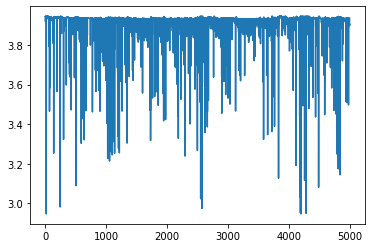

VAL--> Correct: 9 out of 450, acc=0.02
TEST--> Correct: 9 out of 450, acc=0.02


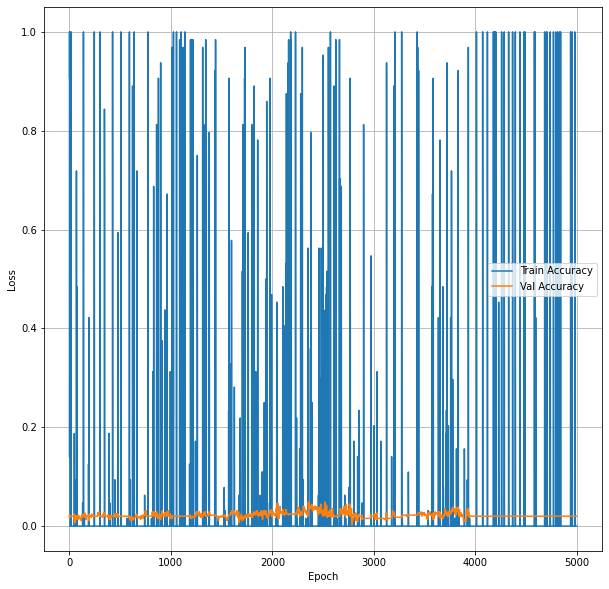

In [37]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = trainDFarray, trainDF["img_label"], valDFarray, valDF["img_label"], testDFarray, testDF["img_label"]
X_train, X_val, X_test = X_train/float(255), X_val/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_test -= np.mean(X_test)
X_val -= np.mean(X_val)

X_train, X_val, X_test = X_train.transpose((0,3,1,2)), X_val.transpose((0,3,1,2)), X_test.transpose((0,3,1,2))

batch_size = 64
D_out = 50

model = LeNet5()

losses = []
#optim = optimizer.SGD(model.get_params(), lr=0.0001, reg=0)
optim = SGDMomentum(model.get_params(), lr=0.0001, momentum=0.80, reg=0.00003)
# optim = Adam(model.get_params(), lr=0.001, beta1=0.9, beta2=0.999, epislon=1e-8)
criterion = CrossEntropyLoss()

train_acc = []
val_acc = []

# TRAIN
ITER = 5000
for i in range(ITER):
    # get batch, make onehot
    X_batch, Y_batch = get_batch(X_train, Y_train, batch_size)
    Y_batch_realnum = Y_batch.copy()
    Y_batch = MakeOneHot(Y_batch, D_out)

    # forward, loss, backward, step
    Y_pred = model.forward(X_batch)
    loss, dout = criterion.get(Y_pred, Y_batch)
    model.backward(dout)
    optim.step()


    print("iter: %s, loss: %s" % (i, loss))
    losses.append(loss)
    
    # TRAIN BATCH SET ACC
    Y_pred = model.forward(X_batch)
    result = np.argmax(Y_pred, axis=1) - Y_batch_realnum
    result = list(result)
    train_acc.append(result.count(0)/X_batch.shape[0])
    
    # VAL SET ACC
    Y_pred = model.forward(X_val)
    result = np.argmax(Y_pred, axis=1) - Y_val
    result = list(result)
    val_acc.append(result.count(0)/X_val.shape[0])


# save params
weights = model.get_params()
with open("weights.pkl","wb") as f:
    pickle.dump(weights, f)

### plot train loss
draw_losses(losses)

### plot acc plot
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(train_acc,label="Train Accuracy")
ax.plot(val_acc,label="Val Accuracy")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid()


# VAL SET ACC
Y_pred = model.forward(X_val)
result = np.argmax(Y_pred, axis=1) - Y_val
result = list(result)
print("VAL--> Correct: " + str(result.count(0)) + " out of " + str(X_val.shape[0]) + ", acc=" + str(result.count(0)/X_val.shape[0]))


# TEST SET ACC
Y_pred = model.forward(X_test)
result = np.argmax(Y_pred, axis=1) - Y_test
result = list(result)
print("TEST--> Correct: " + str(result.count(0)) + " out of " + str(X_test.shape[0]) + ", acc=" + str(result.count(0)/X_test.shape[0]))


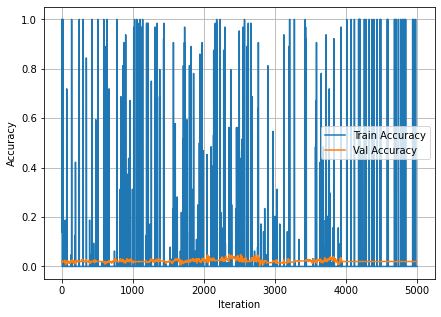

In [38]:
### plot acc plot
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(train_acc,label="Train Accuracy")
ax.plot(val_acc,label="Val Accuracy")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.grid()


In [14]:
# VAL SET ACC
Y_pred = model.forward(X_val)
result = np.argmax(Y_pred, axis=1) - Y_val
result = list(result)
print("VAL--> Correct: " + str(result.count(0)) + " out of " + str(X_val.shape[0]) + ", acc=" + str(result.count(0)/X_val.shape[0]))


# TEST SET ACC
Y_pred = model.forward(X_test)
result = np.argmax(Y_pred, axis=1) - Y_test
result = list(result)
print("TEST--> Correct: " + str(result.count(0)) + " out of " + str(X_test.shape[0]) + ", acc=" + str(result.count(0)/X_test.shape[0]))


VAL--> Correct: 9 out of 450, acc=0.02
TEST--> Correct: 9 out of 450, acc=0.02
